In [141]:
import json
import numpy as np
import seaborn as sns
import sklearn.decomposition
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split


columns = ['opp_switch', 'opp_damage_dealt', 'opp_effectiveness', 'opp_damage_taken', 'opp_heal', 'opp_faint', 'opp_boost_off', 'opp_boost_def', 'opp_boost_spe', 'opp_unboost_off', 'opp_unboost_def', 'opp_unboost_spe', 'opp_basepower', 'opp_accuracy', 'opp_stab', 'opp_priority', 'opp_first', 'switch', 'damage_dealt', 'effectiveness', 'damage_taken', 'heal', 'faint', 'boost_off', 'boost_def', 'boost_spe', 'unboost_off', 'unboost_def', 'unboost_spe', 'basepower', 'accuracy', 'stab', 'priority', 'first', 'turn', 'turn_norm', 'opp_alive', 'alive', 'weight', 'winner', 'opp_winner', 'opp_usage']


In [193]:
with open('datasets/clean/images.json') as fl:
  _data = json.load(fl)

train_images, train_labels, train_poke = list(zip(
  *[(np.array(img), label, poke) for img, label, poke in
    zip(_data['train_images'], _data['train_labels'], _data['train_poke'])
    if np.array(img).shape == np.array(_data['train_images'][0]).shape]
))

test_images, test_labels, test_poke = zip(
	*[(np.array(img), label, poke) for img, label, poke in
	  zip(_data['test_images'], _data['test_labels'], _data['test_poke'])
    if np.array(img).shape == np.array(_data['test_images'][0]).shape]
)

train_labels, test_labels = np.array(train_labels), np.array(test_labels)

In [168]:
print(len(train_images))
print(len(_data['train_images']))
print(len(test_images))
print(len(_data['test_images']))


2246
2246
1860
1862


In [169]:
train_images[0].shape

(5, 42)

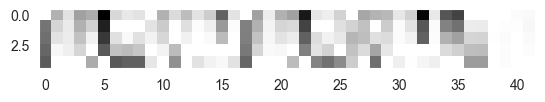

In [170]:
all_images = np.concatenate((train_images, test_images), axis=0)
img = np.mean(all_images, axis=0)
# display(pd.DataFrame(img / img.max(axis=0) , columns=columns))
plt.grid(False)
plt.imshow(img / img.max(axis=0), cmap='gray')

train_images = [x / img.max(axis=0) for x in train_images]
test_images = [x / img.max(axis=0) for x in test_images]
train_images, test_images = np.array(train_images), np.array(test_images)


In [171]:
import umap
reducer = umap.UMAP()
embedding = reducer.fit_transform([img.reshape(5*42) for img in train_images])

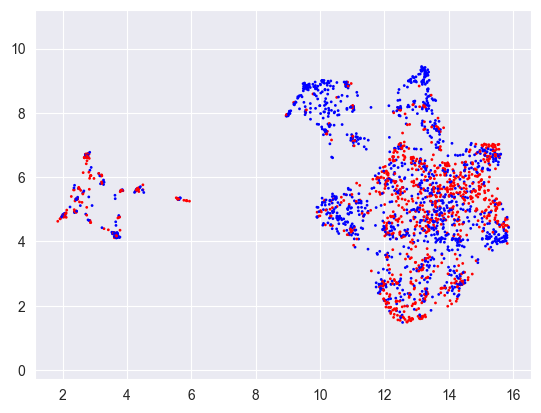

In [172]:
plt.scatter(
  embedding[:, 0],
  embedding[:, 1],
  c=[['r', 'b'][int(x > 0.5)] for x in train_labels],
  s=1)
plt.gca().set_aspect('equal', 'datalim')

In [173]:
import umap
reducer = umap.UMAP()
entry = np.concatenate(train_images, axis=0)
entry_ = np.concatenate(test_images, axis=0)

In [174]:
embedding = reducer.fit_transform(entry)

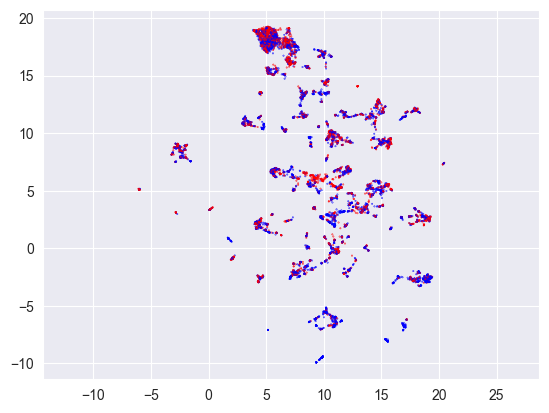

In [175]:
import itertools

row_labels = list(itertools.chain.from_iterable([[x]*5 for x in train_labels]))
plt.scatter(
  embedding[:, 0],
  embedding[:, 1],
  c=[['r', 'b'][int(x > 0.5)] for x in row_labels],
  s=0.1)
plt.gca().set_aspect('equal', 'datalim')

In [176]:
import sklearn
data = sklearn.decomposition.PCA(n_components=24).fit_transform(entry)
train_images_ = np.array(np.split(data, data.shape[0]/5))

data = sklearn.decomposition.PCA(n_components=24).fit_transform(entry_)
test_images_ = np.array(np.split(data, data.shape[0]/5))

In [177]:
train_images = train_images.reshape(len(train_labels), 5, 42, 1)
test_images = test_images.reshape(len(test_labels), 5, 42, 1)
# train_images = train_images_.reshape(len(train_labels), 5, 24, 1)
# test_images = test_images_.reshape(len(test_labels), 5, 24, 1)


In [186]:
import keras
from sklearn.metrics import r2_score
from keras.callbacks import EarlyStopping
from keras import Sequential

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


# cnn regression model
model = Sequential()
model.add(Conv2D(32, (2, 34), activation='relu', input_shape=(5, 42, 1), padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
#model.add(MaxPooling2D((1, 2)))
#model.add(Conv2D(64, (2, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=[r2_score], run_eagerly=True)

early_stop = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(train_images, train_labels, epochs=100, batch_size=32, validation_split=0.3, callbacks=[early_stop])

test_acc = model.evaluate(test_images, test_labels)

# r2 score
pred = model.predict(test_images)
print(r2_score(test_labels, pred))

Epoch 1/100
50/50 [==============================] - 6s 112ms/step - loss: 0.2156 - r2_score: -1.2298 - val_loss: 0.1602 - val_r2_score: -0.7840
Epoch 2/100
50/50 [==============================] - 5s 95ms/step - loss: 0.1465 - r2_score: -0.6636 - val_loss: 0.0926 - val_r2_score: -0.0390
Epoch 3/100
50/50 [==============================] - 6s 117ms/step - loss: 0.1215 - r2_score: -0.3104 - val_loss: 0.0879 - val_r2_score: 0.0286
Epoch 4/100
50/50 [==============================] - 6s 112ms/step - loss: 0.1095 - r2_score: -0.1715 - val_loss: 0.0884 - val_r2_score: 0.0098
Epoch 5/100
50/50 [==============================] - 5s 98ms/step - loss: 0.0955 - r2_score: 0.0087 - val_loss: 0.0935 - val_r2_score: -0.0357
Epoch 6/100
50/50 [==============================] - 6s 125ms/step - loss: 0.0899 - r2_score: 0.0603 - val_loss: 0.0783 - val_r2_score: 0.1280
Epoch 7/100
50/50 [==============================] - 7s 148ms/step - loss: 0.0841 - r2_score: 0.1121 - val_loss: 0.0727 - val_r2_score: 0

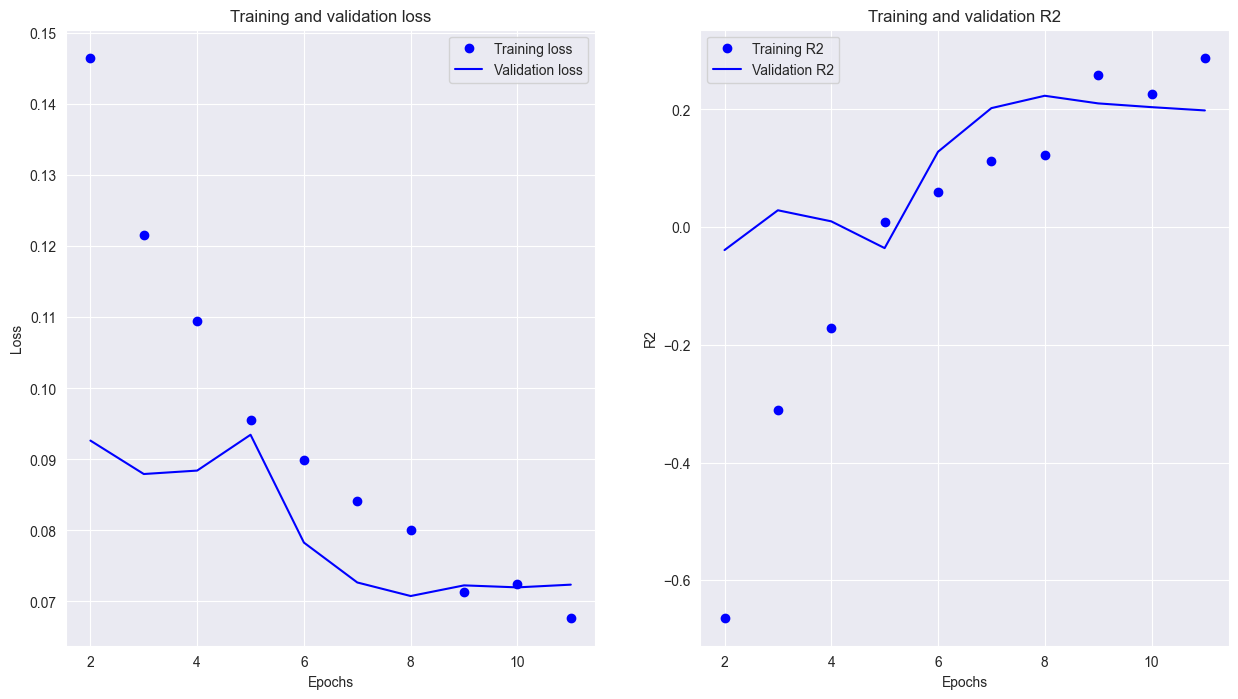

In [187]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['r2_score']
val_acc = history.history['val_r2_score']
epochs = range(1, len(train_loss) + 1)

fig, ax = plt.subplots(1, 2, figsize=(15, 8))

ax[0].plot(epochs[1:], train_loss[1:], 'bo', label='Training loss')
ax[0].plot(epochs[1:], val_loss[1:], 'b', label='Validation loss')
ax[0].set_title('Training and validation loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epochs[1:], train_acc[1:], 'bo', label='Training R2')
ax[1].plot(epochs[1:], val_acc[1:], 'b', label='Validation R2')
ax[1].set_title('Training and validation R2')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('R2')
ax[1].legend()

plt.show()


In [188]:
from itertools import groupby
groups = groupby(sorted(zip(test_images, test_labels, test_poke), key=lambda x: x[-1]), key=lambda x: x[-1])

pred = []
true = []

for k, v in groups:
	images = []
	for data in v:
		true_ = data[1]
		images.append(data[0])
	true.append(true_)
	pred.append(np.mean(model.predict(np.array(images))))


5/5 [==============================] - 0s 7ms/step


In [189]:
r2_score(true, pred)

-0.14975761340419047

In [198]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=50, max_depth=200)
model.fit([img.reshape(5*42) for img in train_images], train_labels)

print('Test Score', r2_score(test_labels, model.predict([img.reshape(5*42) for img in test_images])))

Test Score -0.08968603515049733
